# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl


# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

Ce projet s'intéresse à l'analyse de données décrivant des films obtenues à partir des bases de données du site MovieLens (téléchargée sur http://files.grouplens.org/datasets/movielens/ml-20m.zip) et du site TMDb (téléchargée à travers les liens fournis dans l’énoncé).

La base de données MovieLens contient des fichiers au format CSV tels que: :

* movies : contient pour chaque identifiant de film **movieId**, son titre et les genres auxquels il appartient.
* links : pour chaque identifiant de film **movieId**, ses **imdbId** et **tmdbId** associés ( dont on se servira plus tard pour associer les bases de données de moviesLens et de TMDb )
* ratings : contient pour chaque identifiant représentant un utilisateur **userId**, la note **rating** /5 qu'il a donné à un film d'identifiant **movieId** il y a un temps donné ( **timestamp**)
* tags :  contient pour chaque identifiant représentant un utilisateur **userId**, un commentaire **tag** qu'il a écrit sur un film d'identifiant **movieId** il y a un temps donné ( **timestamp**)

La base de TMDb contient des informations sur des acteurs, avec la liste des acteurs de chaque film et des informations comme leur nom, genre et le personnage qu’ils ont joué. Elle contient aussi des informations sur les films, avec leur titre, description, date de sortie, langue originelle et moyenne des votes. Finalement, elle contient aussi des informations sur l’équipe de production de chaque film, avec leurs noms, genres et rôles.

## Chargement des données (base MovieLens + enrichissements)

In [4]:

fname = 'crew_v2.pkl'
crew = pkl.load(open(fname, "rb"))
fname = 'film_v2.pkl'
films = pkl.load(open(fname, "rb"))
fname = 'act_v2.pkl'
acteurs = pkl.load(open(fname, "rb"))

movies = pd.read_csv( "movies.csv")
movies_pd=pd.read_csv("movies.csv", index_col = 0)
links=pd.read_csv('links.csv',encoding='utf8')
ratings=pd.read_csv('ratings.csv')
tags= pd.read_csv( "tags.csv", encoding="utf-8")

In [35]:
crew[0]
films[2]
acteurs[0]

[{'cast_id': 14,
  'character': 'Woody (voice)',
  'credit_id': '52fe4284c3a36847f8024f95',
  'gender': 2,
  'id': 31,
  'name': 'Tom Hanks',
  'order': 0,
  'profile_path': '/xxPMucou2wRDxLrud8i2D4dsywh.jpg'},
 {'cast_id': 15,
  'character': 'Buzz Lightyear (voice)',
  'credit_id': '52fe4284c3a36847f8024f99',
  'gender': 2,
  'id': 12898,
  'name': 'Tim Allen',
  'order': 1,
  'profile_path': '/dDbtWMGdhatUjCIYolc312R2ygu.jpg'},
 {'cast_id': 16,
  'character': 'Mr. Potato Head (voice)',
  'credit_id': '52fe4284c3a36847f8024f9d',
  'gender': 2,
  'id': 7167,
  'name': 'Don Rickles',
  'order': 2,
  'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'},
 {'cast_id': 17,
  'character': 'Slinky Dog (voice)',
  'credit_id': '52fe4284c3a36847f8024fa1',
  'gender': 2,
  'id': 12899,
  'name': 'Jim Varney',
  'order': 3,
  'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'},
 {'cast_id': 18,
  'character': 'Rex (voice)',
  'credit_id': '52fe4284c3a36847f8024fa5',
  'gender': 2,
  'id': 12900,
 

Afin de visualiser les données, nous pouvons utiliser les fonctions comme **describe()** qui nous renseigne sur la moyenne, le minimum, le maximum, l'écart type etc des données *numériques*

In [36]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Mais nous allons surtout nous aider d'histogrammes afin de pouvoir visualiser la répartition des données assez simplement. 
Premièrement nous souhaitons savoir de quelle fréquence les notes sont attribuées.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1406f77f0>]],
      dtype=object)

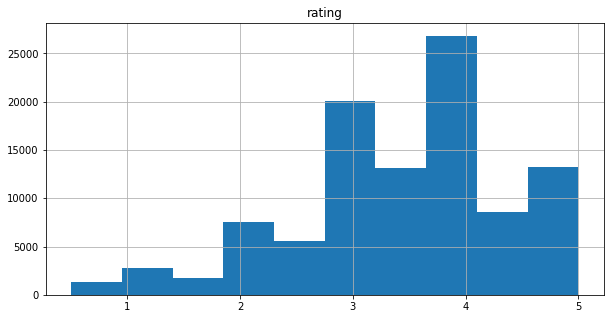

In [37]:
ratings.hist(column='rating', figsize=(10,5))


On remarque que la note que les utilisateurs mettent le plus est la note de 4/5 ( qui a été attribuée plus de 25000 fois ) ce qui nous a amené à une reflexion que l'on traite plus tard dans le projet.


Toujours dans le cadre de la compréhension des données, on souhaite connaitre la popularité des genres. Donc savoir pour chaque catégorie, le nombre de films qui sont comptés dedans.

In [38]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
                
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)

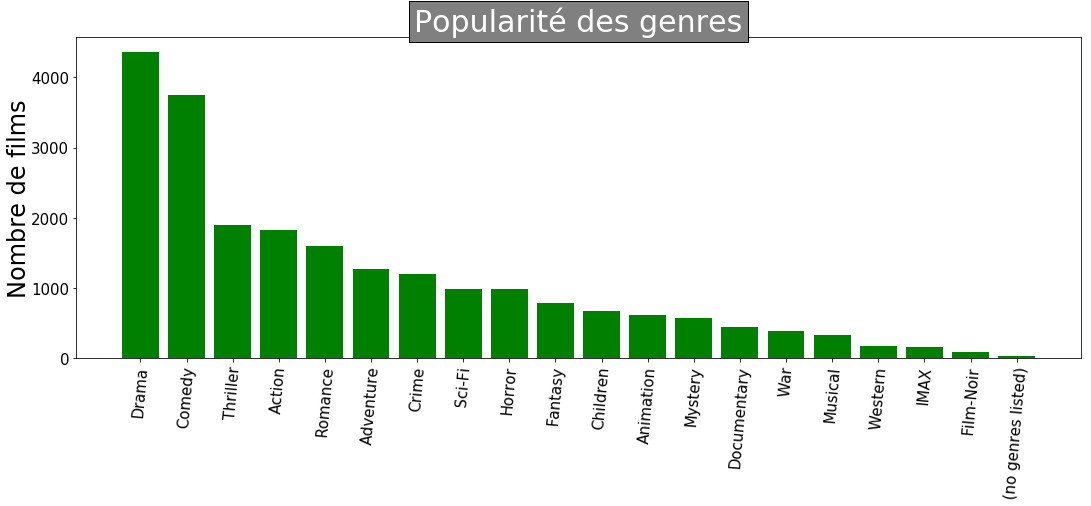

In [39]:
trunc_occurences = keyword_occurences[0:50]
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nombre de films", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
plt.title("Popularité des genres",bbox={'facecolor':'grey', 'pad':5},color='w',fontsize = 30)
plt.show()

Toujours dans la même logique, on souhaite connaitre les mots les plus utilisés dans les commentaires écrits par les utilisateurs. 
On prendra les 15 mots les plus présents car après, leurs fréquences d'apparitions est trop similaire. ( dailleurs, a part *"in Netflix queue"* , et *"atsmospheric"*, les autres commentaires ont tous une fréquence d'apparition d'à peu près 20 )

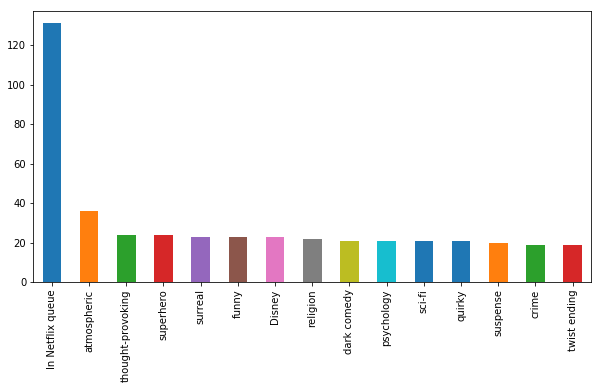

In [40]:
Nb_commentaires = tags['tag'].value_counts()
Nb_commentaires[:15].plot(kind='bar', figsize=(10,5))

On veut a présent mettre sous forme de Data Frame les informations que nous utiliserons par la suite.

Pour cela, nous definissons un tableau regrouprant tous les groupes décris par la bd, dont *"no genres listed"* pour pouvoir dire si un film appartient à certaines de ces catégories. Nous utiliserons le principe du dummy coding en rajoutant une colonne pour chaque genre, avec une entrée -1 si le film n’est pas de ce genre et +1 s’il l’est.

Puis nous rassemblons toutes les données que nous utiliserons par la suite  dans un même DataFrame (appelé movies_pd) tel que pour chaque movieId, soient presentes les informations suivantes  : 

* le titre du film **title** 
* les catégories auxquels ce film appartient (+1) ou non (-1)
* la **Note Moyenne** attribuée par les internautes
* le nombre de notes **NbNotes**
* le nombre de commentaires écris par les internautes sur ce films **NbCommentaires**



In [41]:
genres = ["Action", "Adventure", "Animation", "Children", "Comedy", \
          "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", \
          "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", \
          "Western", "(no genres listed)"]

for g in genres:
    movies_pd[g.lower()] = movies_pd.apply(lambda r: 2*int(g in r["genres"]) - 1, axis=1)
    
movies_pd["Note moyenne"] = ratings.groupby("movieId")["rating"].mean()
movies_pd["NbNotes"] = ratings.groupby("movieId")["rating"].count()
movies_pd["NbCommentaires"]=tags.groupby("movieId")["tag"].count()

movies_pd["Note moyenne"].fillna(0, inplace = True)
movies_pd["NbNotes"].fillna(0, inplace = True)

movies_pd=movies_pd.drop(['genres'],axis=1)



In [42]:
movies_pd.head(1)

,title,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,...,mystery,romance,sci-fi,thriller,war,western,(no genres listed),Note moyenne,NbNotes,NbCommentaires
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),-1,1,1,1,1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,3.92093,215.0,3.0


# Classification supervisé

Après avoir observé la répartition des notes sur l'histogramme ci dessus, nous faisons donc l'hypothèse que les gens ont plus de "facilité" à mettre de bonnes notes que de mauvaises. Pour approfondir cette hypothèse, on cherche maintenant à savoir si lorsque les gens s'expriment sur un film, c'est pour le dénigrer ou le louer.

Pour cela, on pose la note de 3/5 à partir de laquelle on admet que c'est une bonne note et nous allons  essayer de prédire si un film obtient une bonne note en fonction du nombre de votes ainsi que du nombre de commentaires écrit par les internautes.



on change la fonction vecteur a chaque fois 

Pour faciliter la manipulation des données ( qui sont dans des bases de données différentes ), on les regroupe : on veut pour chaque tmdbId (links) de film, sa note (ratings), le nombre de votes (films) et le nombre de commentaires (tags)

In [43]:
#Cette fonction compte le nombre de commentaires par film
def nb_comm(tags):
    nb_com={}
    for i in range (0,len(tags)):
        j=tags["movieId"][i]
        if j in nb_com:
            total=nb_com[j]
            total+=1
            nb_com[j]=total
        else:
            nb_com[j]=1
    return nb_com

In [9]:
#Cette fonction calcule la note moyenne attribuée à un film en fonction de toutes les notes données a ce films par les internautes
def getAverageNote():
    moyy=ratings.groupby(['movieId'], as_index=False).mean()
    liste=[]
    for i in range(0,len(moyy)):
        liste.append((moyy['movieId'][i],moyy['rating'][i]))
    return liste 


In [45]:
#Cette fonction associe à chaque identifiant d'un film, le nombre total de vote qu'il a reçu ainsi que sa note moyenne
def id_nb_vote_com_note():
    imdb={}
    average=getAverageNote()
    nb_mot=nb_comm(tags)
    for i in range(0,len(links)):
        L=[]
        L.append(films[i]['vote_count'])  
        imdb[links["movieId"][i]]=L
        if i in nb_mot:
            L.append(nb_mot[i])
            imdb[i]=L
        else:
            L.append(0)
            imdb[i]=L
            

    for j,moy in average:
        L=imdb[j]
        L.append(moy)
        imdb[j]=L
    
    return imdb
imdb=id_nb_vote_com_note()
imdb[1]

[5594, 3, 3.9209302325581397]

On creer un vecteur ***X : [nb_votes,nb_commentaires]*** et un vecteur ***Y : [note_moyenne]*** pour pouvoir par la suite l'inserer facilement dans un LabelSet.

*NB : Chaque problématique est différente et se resout avec des paramètres descritpifs de dimensions différentes. C'est pourquoi la fonction creer_vecteur est propre à chaque labeleSet créé.*

In [67]:
def creer_vecteur(data):
    vecteur_x=[]
    vecteur_y=[]
    for i in data:
        if (len(data[i])==3):
            if (data[i][2]>=3):
                vecteur_y.append(1)
            else:
                vecteur_y.append(-1)
            
            vecteur_x.append((data[i][0],data[i][1]))
    return vecteur_x,vecteur_y
    
x,y=creer_vecteur(imdb)   
x.remove((43, 181))

In [17]:
#Cette fonction prend en argument deux vecteurs, et les ajoute comme exemples dans un LabelSet
def labellé(x,y):

    data_set = ls.LabeledSet(2)

    for i in range(0,len(x)) :
        data_set.addExample(x[i],y[i])

    return data_set


In [69]:
data_set=labellé(x,y)

On présente les données graphiquement afin de pouvoir mieux les visualiser

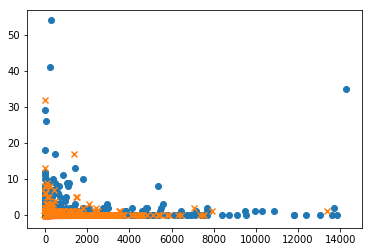

In [70]:
ut.plot2DSet(data_set)

- En bleu, les films ayant reçu des notes >=3 
- En orange, les films ayant reçu des notes < 3
- En abscisse, le nombre de votes 
- En ordonné, le nombre de commentaires

L'echelle prise pour la représentation des données est trop grande et ne nous permet pas de les visualiser correctement . En effet, certains points sont trop eloignés des autres alors que d'autres sont très regoupés et peu visibles sur ce graphique.

Pour remedier à cela, nous allons nous limiter à une echelle allant de 0 à 2000 pour le nombre de votes et de 0 à 10 pour le nombre de commentaires.

In [71]:
def creer_vecteur_bis(data):
    vecteur_x=[]
    vecteur_y=[]
    for i in data:
        if (len(data[i])==3):
            if (data[i][2]>=3):
                vecteur_y.append(1)
            else:
                vecteur_y.append(-1)
            if (data[i][0]<=2000 and data[i][1]<=10):
                vecteur_x.append((data[i][0],data[i][1]))
    return vecteur_x,vecteur_y
    
x,y=creer_vecteur_bis(imdb)   
#x.remove((43, 181))

In [72]:
data_set=labellé(x,y)

In [73]:
#Cette fonction sépare la base de données en deux afin de pouvoir entrainer puis tester notre modèle sur des exemples du Labelset tirés aléatoirement mais cohérents ( ne pas tester sur un exemple ou il a deja apprit )
def split(data):
    ind=np.random.permutation(data.size())
    data_app=ls.LabeledSet(2)
    data_test=ls.LabeledSet(2)
    for i in range (int(data.size()/2)):
        data_app.addExample(data.getX(ind[i]),data.getY(ind[i]))
    for j in range (i,data.size()):
        data_test.addExample(data.getX(ind[j]),data.getY(ind[j]))
    return data_app, data_test

data_app, data_test = split(data_set)

0.7125958378970427


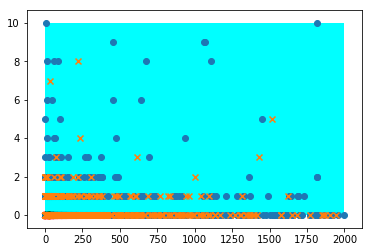

In [74]:
#On applique le modèle des K-plus proche voisins.
knn = cl.ClassifierKNN(2,100)
knn.train(data_app)

print(knn.accuracy(data_test))
ut.plot_frontiere(data_test,knn,20)
ut.plot2DSet(data_test) 

Visuellement parlant, il n'est pas evident que le modèle utilisé soit fonctionnel pour la resolution de notre problématique. De plus l'accuracy qui est de 0,71 nous montre que le nombre de votes et le nombre de commentaires ne sont pas suffisants pour prédire la note. 

On peut tout de même voir graphiquement que les points bleus (note>=3) sont plus présents que les oranges (note<3) lorsque le nombre de commentaires et de votes augmentent. 

Par cette analyse, nous pouvons continuer à explorer l'hypothèse que les utilisateurs s'expriment plus lorsque leurs avis sur un film sont positifs.


Pour être sur de nos resultats, nous allons appliquer le modèle du classifieur Percepton, afin de valider ou annuler nos reslutats précédents.

0.707776560788609


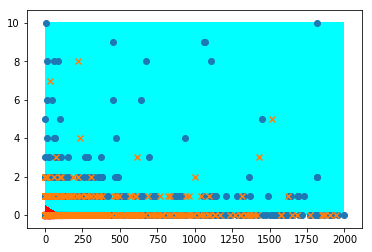

In [80]:
p = cl.ClassfierPerceptron(2,0.000001)
p.train(data_app,100)

#Tester le modele
ut.plot_frontiere(data_test,p)
ut.plot2DSet(data_test)
print(p.accuracy(data_test))

Nous trouvons les mêmes resulats qu'avec le classifieur des K plus proches voisins. Donc il n'y a pas de classifieur mieux que l'autre.

Nous allons tout de même observer l'évolution de l'accuracy des deux classifieurs.


In [52]:
knn=cl.ClassifierKNN(2,1)
knn.train(data_app)
x=[]
y=[]
z=[]
res1=[]
res2=[]
for i in range (20):
    un_classifieur = cl.ClassfierPerceptron(2,0.000001)
    x.append(i)
    z.append(un_classifieur.accuracy(data_test))
    knn=cl.ClassifierKNN(2,i)
    knn.train(data_app)
    y.append(knn.accuracy(data_test))
    res1.append(un_classifieur.accuracy(data_test))
    res2.append(knn.accuracy(data_test))

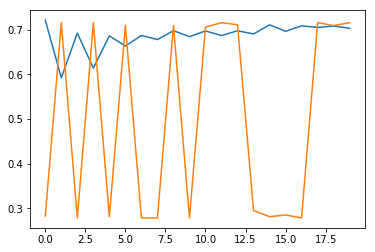

In [56]:
plt.plot(x,y)
plt.plot(x,z)

Sur ce graphe représentant l'évolution de l'accuracy des classifieurs *Perceptron* (en orange) et *Knn* (en bleu), on a l'impression que l'accuracy du Perseptron n'est pas stable, mais c'est seulement une erreur du modèle, qui parfois, inverse les labels. Cependant, ce n'est pas une erreur à prendre en compte dans le résultat final.

## Regression supervisé

Toujours dans la même problématique de savoir si lorsque les gens s'expriment sur un film, c'est pour le dénigrer ou le louer. Nous allons aborder un problème de regression supervisé en essayant de predire la note d'un film donnée par les internautes, en fonction du nombre de mots total des commentaires de ce film.

In [5]:
#Cette fonction compte le nombre total de mot des commentaires pour chaque films
def nb_mot_total(data):
    nb_mot={}
    for i in range (0,len(data)):
        liste=[]
        liste_temp=[]
        liste_temp=data["tag"][i].split(' ')
        somme=len(liste_temp)
        j=data["movieId"][i]
        if j in nb_mot:
            total=nb_mot[j]
            total+=somme
            nb_mot[j]=total
        else:
            nb_mot[j]=somme
    return nb_mot
n=nb_mot_total(tags)

In [12]:
#A chaque film on lui associe sa note et le nombre de mot présents dans ses commentaires
def id_note_nbmot(ratings,tags):
    
    liste=[]
    average=getAverageNote()
    nb=nb_mot_total(tags)
    dic={}
    
    for j in nb:
        L=[]
        L.append(nb[j])
        dic[j]=L

    for i, moy in average:
        if i in dic:
            L=dic[i]
            L.append(moy)
            dic[i]=L

    return dic

In [13]:
i=id_note_nbmot(ratings,tags)

In [14]:
#encore une fois, on creer un vecteur pour pouvoir ajouter l'exemple dans un labelset 
def creer_vecteur1(data):
    vecteur_x=[]
    vecteur_y=[]
    for i in data:
        if (len(data[i])==2):   
            vecteur_x.append(data[i][0])
            vecteur_y.append(data[i][1])
    return vecteur_x,vecteur_y

In [15]:
x,y=creer_vecteur1(i)

In [18]:
data_set=labellé(x,y)

In [19]:
# sklearn library
import math
from sklearn.linear_model import LinearRegression
# linear regression model
linear_reg = LinearRegression()

x = np.reshape(x, (1, -1)).T
y = np.reshape(y, (1, -1)).T

linear_reg.fit(x,y)

print('R square: ', linear_reg.score(x, y))
print('Correlation: ', math.sqrt(linear_reg.score(x, y)))

R square:  0.0062217227096326155
Correlation:  0.07887789747218554


On remarque que le score de regression est très mauvais. 
Ainsi, notre modèle de regression n'a pas reussis a predire les notes en fonction du nombre total des mots contenus dans les commentaires.

On remarque aussi que le coefficient de corrélation est très faible, ce qui signifie que le nombre de mots des commentaires n'est pas un descriptif assez important pour prédire la note. 

Visualisons ces données graphiquement : 

array = np.arange(300).reshape(-1,1)
plt.scatter(x,y)
y_head = linear_reg.predict(array)  
plt.plot(array, y_head,color = "red")
array = np.array([100]).reshape(-1,1)
linear_reg.predict(array)
plt.show()

On remarque sur ce graphe que les points ne sont pas repartis de façon uniforme autour de la droite. Ce qui explique le coefficient de corrélation. 
Pour pouvoir prédire la note, il faudrait rajouter des variables qui ont un effet sur la variable expliquée, c’est-à-dire des variables de contrôle.

Malgré le faible pouvoir explicatif de cette régression, on note que le coefficient de corrélation associé au nombre de mots est de signe positif ce qui suggère que les gens auraient plutôt tendances a laisser des commentaires pour exprimer une opinion positives sur les films plutôt que négative 

Pour conclure, cette première analyse des notes attribuées aux films en fonction des commentaires est un peu décevante
Nous aimerions, en disposant de plus de temps, la compléter afin de prendre en compte parmis les variables explicatives non seulement le nombre de mots mais aussi mais le nombre de commentaires ( donc le nombre de mots par aux commentaires). Joue également certainement le mois de sortie du film, la réputation du realisateur et des acteurs etc.


## Catégorisation non supervisée

Dans cette partie, nous allons essayer d'étudier les préférences cinématographique des utilisateurs en terme de catégorie de films. 
Nous allons prendre deux catégories : Romance et Horror, qui nous sembles opposés. 
Nous allons utiliser l'algorithme des K-moyennnes pour avoir en sorti, des groupes formés à partir des valeurs descriptives données.


La fonction get_genre_ratings calcule la note moyenne de chaque utilisateur pour tous les films d'amour et tous les films d'horreur. Partitionnons un peu notre ensemble de données en supprimant les personnes qui aiment à la fois l'horreur et la romance, afin que nos clusters aient tendance à les définir comme aimant un genre plus que l'autre.

Comme notre algorithme des k-moyennes ne fonctionne pas bien, nous avons utilisé celui de la librairie "sklearn".

In [75]:

def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

In [76]:

genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Horror'], ['avg_romance_rating', 'avg_horror_rating'])
genre_ratings.head()

,avg_romance_rating,avg_horror_rating
userId,,
1,4.31,3.47
2,4.50,3.00
3,0.50,4.69
4,3.38,4.25
5,3.09,3.00


In [77]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 ) & (genre_ratings['avg_horror_rating'] > score_limit_2)) | ((genre_ratings['avg_horror_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [78]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.5, 2.5)

print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  293


,userId,avg_romance_rating,avg_horror_rating
0,1,4.31,3.47
1,2,4.50,3.00
2,3,0.50,4.69
3,4,3.38,4.25
4,5,3.09,3.00


Nous pouvons donc constater que nous avons 193 utilisateurs, et pour chaque utilisateur, nous avons leur évaluation moyenne des films de romance et de films d'horreurs qu’ils ont visionnés.

Visualisons ces données :

In [79]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

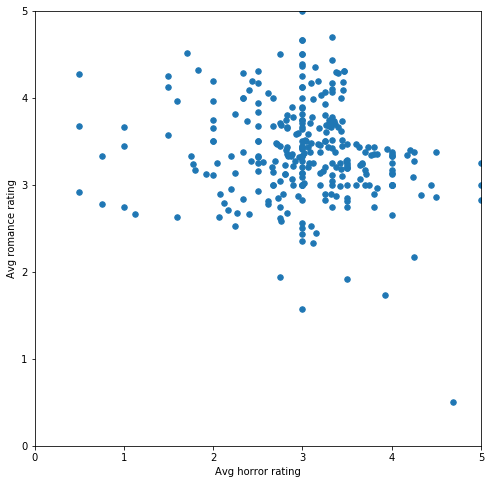

In [80]:
draw_scatterplot(biased_dataset['avg_horror_rating'],'Avg horror rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

Nous pouvons constater un biais évident dans cet échantillon (que nous avons créé exprès). À quoi ressemblerait-il si nous divisions l'échantillon en deux groupes à l'aide de k-moyennes?

In [81]:
#Nous transformons notre Dataframe en liste
X = biased_dataset[['avg_horror_rating','avg_romance_rating']].values

* Importer [KMeans] (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
* Préparer KMeans avec n_clusters = 2
* Passez l'ensemble de données **X** à la méthode fit_predict de KMeans et récupérez les étiquettes de regroupement dans *prédictions*

In [82]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg horror rating')
    ax.set_ylabel('Avg romance rating')
    

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_horror_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

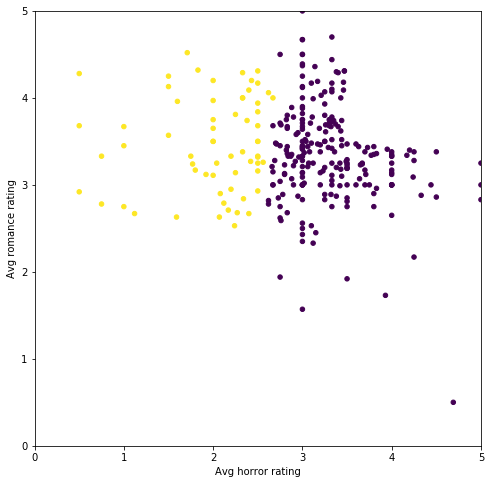

In [83]:
from sklearn.cluster import KMeans 
kmeans_1 = KMeans(n_clusters=2)
predictions = kmeans_1.fit_predict(X)

draw_clusters(biased_dataset, predictions)

Nous pouvons voir que les groupes sont principalement basés sur la façon dont chaque personne a évalué les films d'horreur. Si leur cote moyenne de films d'horreur est supérieure à 2,5 étoiles, ils appartiennent à un groupe. Sinon, ils appartiennent à l'autre groupe.
Que se passerait-il si nous les divisions en trois groupes?

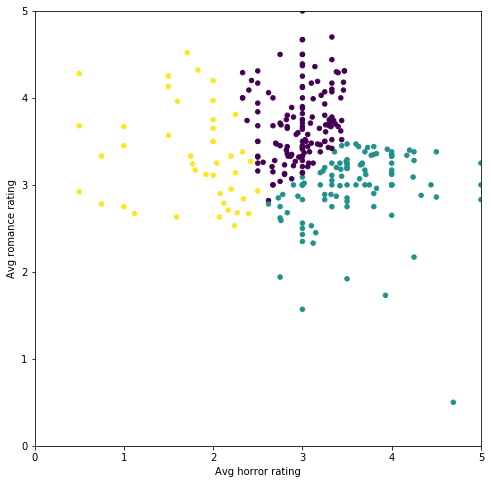

In [86]:
from sklearn.cluster import KMeans 
kmeans_1 = KMeans(n_clusters=3)
predictions = kmeans_1.fit_predict(X)

draw_clusters(biased_dataset, predictions)

Maintenant, la note moyenne en romance commence à jouer. Les groupes sont:
 * les gens qui aiment la romance mais pas les films d'horreur ( jaune )
 * les gens qui aiment les films d'horreurs mais pas la romance ( vert )
 * les gens qui aiment les films d'horreurs et la romance ( violet )
 
Ajoutons encore un groupe

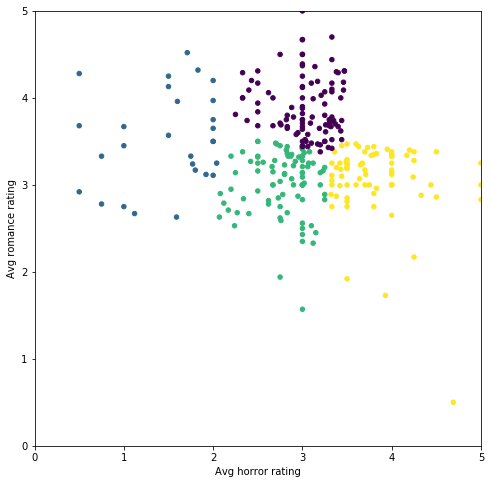

In [90]:
from sklearn.cluster import KMeans 
kmeans_1 = KMeans(n_clusters=4)
predictions = kmeans_1.fit_predict(X)

draw_clusters(biased_dataset, predictions)

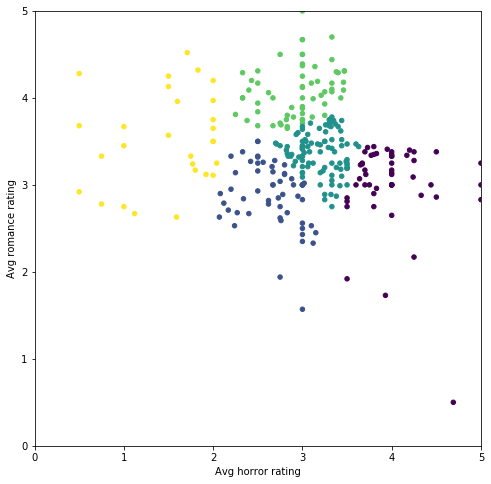

In [92]:
from sklearn.cluster import KMeans 

kmeans_1 = KMeans(n_clusters=5)
predictions = kmeans_1.fit_predict(X)

draw_clusters(biased_dataset, predictions)

Nous pouvons constater que plus nous divisons notre ensemble de données en groupes, plus les goûts de la population de chaque groupe se ressemblent.